# Use Keras and hyperparameter optimization (HPO) to recognize hand-written digits with `ibm-watsonx-ai`

This notebook contains steps and code to demonstrate support of Deep Learning experiments in the Watson Machine Learning service. It introduces commands for data retrieval, training definition persistance, experiment training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Working with the Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of the trained model.

## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Create model definition](#model_def)
3. [Train model](#training)
4. [Persist trained model](#persist)
5. [Deploy and Score](#deploy)
6. [Clean up](#clean)
7. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [ ]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.1"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.1"
)

```

In [3]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.1/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [2]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="model_def"></a>
# 2. Create model definition

For the purpose of this example two Keras model definitions have been prepared:

 - Multilayer Perceptron (MLP)
 - Convolution Neural Network (CNN)

### 2.1 Prepare model definition metadata

In [5]:
metaprops = {
    client.model_definitions.ConfigurationMetaNames.NAME: "MNIST mlp model definition",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "MNIST mlp model definition",
    client.model_definitions.ConfigurationMetaNames.COMMAND: "mnist_mlp.py",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.11"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
}

### 2.2 Get sample model definition content files from git (Python scripts with CNN and MLP)

In [ ]:
import os, wget

filename_mnist = 'MNIST.zip'

if not os.path.isfile(filename_mnist):
    filename_mnist = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd5.1/definitions/keras/mnist/MNIST.zip')

**Tip**: Convert below cell to code and run it to see model deinition's code.

### 2.3 Publish model definition

In [8]:
model_definition_details = client.model_definitions.store(filename_mnist, meta_props=metaprops)

In [9]:
model_definition_id = client.model_definitions.get_id(model_definition_details)
print(model_definition_id)

7516a11a-8f7c-4ab4-8933-79a8a8415266


#### List model definitions

In [ ]:
client.model_definitions.list(limit=5)

<a id="training"></a>
# 3. Train model

#### **Warning**: Before executing deep learning experiment make sure that [training data](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.1/data/mnist/mnist.npz) is saved in a folder where Watson Machine Learning Accelerator is installed.

### 3.1 Prepare training metadata

In [12]:
training_metadata = {
    client.training.ConfigurationMetaNames.NAME: "Keras-MNIST",
    client.training.ConfigurationMetaNames.DESCRIPTION: "Keras-MNIST predict written digits",
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE:  {
      "name":"MNIST results",
      "connection":{
         
      },
      "location":{
         "path":f"spaces/{space_id}/assets/experiment"
      },
      "type":"fs"
   },
  client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_id,
        "hardware_spec": {
          "name": "K80",
          "nodes": 1
        },
        "software_spec": {
          "name": "tensorflow_rt24.1-py3.11"
        }
      },
  client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: [
      {
         "name":"training_input_data",
         "type":"fs",
         "connection":{
            
         },
         "location":{
            "path": "tf-mnist"
         },
         "schema":{
            "id":"idmlp_schema",
            "fields":[
               {
                  "name":"text",
                  "type":"string"
               }
            ]
         }
      }
   ]
}

### 3.2 Train model in background

In [13]:
training = client.training.run(training_metadata)

### 3.3 Get training id and status

In [14]:
training_id = client.training.get_id(training)

In [ ]:
client.training.get_status(training_id)["state"]

### 3.4 Get training details

In [ ]:
import json

training_details = client.training.get_details(training_id)
print(json.dumps(training_details, indent=2))

#### List trainings

In [ ]:
client.training.list(limit=5)

#### Cancel training

You can cancel the training run by calling the method below.  
**Tip**: If you want to delete train runs and results add `hard_delete=True` as a parameter.

<a id="persist"></a>
# 4. Persist trained model

### 4.1 Publish model

In [31]:
software_spec_id = client.software_specifications.get_id_by_name('tensorflow_rt24.1-py3.11')

In [ ]:
model_meta_props = {
    client.repository.ModelMetaNames.NAME: "Keras MNIST",
    client.repository.ModelMetaNames.TYPE: "tensorflow_2.14",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: software_spec_id,
}

published_model = client.repository.store_model(training_id, meta_props=model_meta_props)
model_id = client.repository.get_model_id(published_model)

### 4.2 Get model details

In [ ]:
model_details = client.repository.get_details(model_id)
print(json.dumps(model_details, indent=2))

#### List stored models

In [ ]:
client.repository.list_models(limit=5)

<a id="deploy"></a>
# 5. Deploy and score

### 5.1 Create online deployment for published model

In [45]:
deployment = client.deployments.create(
    model_id, meta_props={
        client.deployments.ConfigurationMetaNames.NAME: "Keras MNIST",
        client.deployments.ConfigurationMetaNames.ONLINE: {}
        }
    )

deployment_id = client.deployments.get_id(deployment)



#######################################################################################

Synchronous deployment creation for uid: '45a2b1bb-59a6-4d40-ab43-39d348ca471f' started

#######################################################################################


initializingNote: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='498157f7-8576-4bd4-8f05-0ae8d695f2c7'
---------------------

### 5.2 Get deployments details

In [ ]:
deployments_details = client.deployments.get_details(deployment_id)
print(json.dumps(deployments_details, indent=2))

#### List deployments

In [ ]:
client.deployments.list(limit=5)

### 5.3 Score deployed model

Let's plot two digits. **Action:** Please install `matplotlib`, `numpy`

In [ ]:
import wget

dataset_filename='mnist.npz'

if not os.path.isfile(dataset_filename):
    dataset_filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd5.1/data/mnist/mnist.npz')

In [48]:
import numpy as np

mnist_dataset = np.load(dataset_filename)
x_test = mnist_dataset['x_test']

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

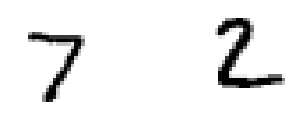

In [50]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Our input node expects to get data with shape (784,) so we need to reshape our two digits.

In [51]:
image_1 = x_test[0].ravel() / 255
image_2 = x_test[1].ravel() / 255

#### Prepare scoring payload and score.

In [52]:
scoring_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA : [
        {'values': [image_1.tolist(), image_2.tolist()]}
    ]
}
scores = client.deployments.score(deployment_id, meta_props=scoring_payload)
print("Scoring result:\n" + json.dumps(scores, indent=2))

Scoring result:
{
  "predictions": [
    {
      "id": "dense_2",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            3.728355935095351e-08,
            2.211097012150276e-07,
            1.2561032235680614e-05,
            2.3223246898851357e-05,
            7.352957132056304e-10,
            5.163227001503401e-07,
            4.822294993878096e-11,
            0.9999523162841797,
            8.347302582478733e-08,
            1.1019522389688063e-05
          ],
          7,
          [
            3.728355935095351e-08,
            2.211097012150276e-07,
            1.2561032235680614e-05,
            2.3223246898851357e-05,
            7.352957132056304e-10,
            5.163227001503401e-07,
            4.822294993878096e-11,
            0.9999523162841797,
            8.347302582478733e-08,
            1.1019522389688063e-05
          ]
        ],
        [
          [
            

<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.1/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

You successfully completed this notebook! You learned how to use `ibm-watsonx-ai` to run experiments.  

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020-2025 IBM. This notebook and its source code are released under the terms of the MIT License.